# Simulating Heston Model in Python

<b> YouTube Tutorial </b> (Published:
Mar 18, 2022): https://youtu.be/o8C6DxZh8dw

### Heston Model

#### Euler Discretisation of SDEs

$\Large dS_{i+1} = S_i e^{(r-\frac{V_i}{2}) \Delta t + \sqrt{V_{i}}\Delta tW{S,i+1}}$
    
$\large V_{i+1} = V_i + \kappa(\theta - V_t)\Delta t +\sigma \sqrt{V_i} \Delta t W_{v,i+1}$

In [ ]:
!pip install py_vollib_vectorized


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Import Dependencies

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
from scipy.optimize import minimize

#### Realized variance $V_t$ proxy

In [ ]:
df_old = pd.read_csv('VNI.csv')

df_test_norm = pd.read_csv('VN Index Historical Data.csv')

df_test_norm = df_test_norm.iloc[::-1].reset_index(drop=True)

df_old['Date'] = pd.to_datetime(df_old['Date'], format='%m/%d/%Y')
df_test_norm['Date'] = pd.to_datetime(df_test_norm['Date'], format='%m/%d/%Y')

df_test_norm = df_test_norm.drop(columns=['Change %'])  # Optional

merged_df = pd.concat([df_old, df_test_norm], ignore_index=True)


merged_df = merged_df.sort_values('Date')

merged_df['Price'] = merged_df['Price'].replace({',': ''}, regex=True).astype(float)

print(merged_df.info())
print(merged_df.tail())
print("Number of NaN values in Price:", merged_df['Price'].isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 0 to 3299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3300 non-null   datetime64[ns]
 1   Price   3300 non-null   float64       
 2   Open    3300 non-null   object        
 3   High    3300 non-null   object        
 4   Low     3300 non-null   object        
 5   Vol.    3300 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 180.5+ KB
None
           Date    Price      Open      High       Low     Vol.
3295 2025-03-24  1330.32  1,322.90  1,330.32  1,316.73  926.62M
3296 2025-03-25  1331.92  1,330.32  1,337.60  1,329.81    1.02B
3297 2025-03-26  1326.09  1,331.92  1,338.55  1,323.69  834.63M
3298 2025-03-27  1323.81  1,326.09  1,328.82  1,323.01  672.32M
3299 2025-03-28  1317.46  1,324.42  1,325.34  1,315.72  739.65M
Number of NaN values in Price: 0


In [ ]:
merged_df['Log_Return'] = np.log(merged_df['Price'] / merged_df['Price'].shift(1))
merged_df = merged_df.dropna()

,Date,Price,Open,High,Low,Vol.,Log_Return
3295,2025-03-24,1330.32,"1,322.90","1,330.32","1,316.73",926.62M,0.006365
3296,2025-03-25,1331.92,"1,330.32","1,337.60","1,329.81",1.02B,0.001202
3297,2025-03-26,1326.09,"1,331.92","1,338.55","1,323.69",834.63M,-0.004387
3298,2025-03-27,1323.81,"1,326.09","1,328.82","1,323.01",672.32M,-0.001721
3299,2025-03-28,1317.46,"1,324.42","1,325.34","1,315.72",739.65M,-0.004808


In [ ]:

def calculate_realized_volatility(df, log_return_col='Log_Return', epsilon=5, J=5):
    """
    Calculate realized volatility over sliding windows.

    Args:
        df (pd.DataFrame): DataFrame containing log returns.
        log_return_col (str): Column name for log returns.
        epsilon (int): Length of the sliding time window.
        J (int): Number of partitions in the sliding window.

    Returns:
        pd.Series: Realized volatility for each time point.
    """
   
    realized_vols = []

   
    partition_intervals = epsilon / J  
    window = int(J) + 1  

    for i in range(len(df)):

        start = max(0, i - window + 1)
        end = i + 1 
        window_returns = df[log_return_col].iloc[start:end]

        squared_diffs = np.diff(window_returns) ** 2

        realized_vol = np.sum(squared_diffs) / epsilon
        realized_vols.append(realized_vol)

    df['Realized_Volatility'] = realized_vols

    return df

epsilon = 5  # Number of trading days in a month
J = epsilon   # Equal partitions
merged_df = calculate_realized_volatility(merged_df, log_return_col='Log_Return', epsilon=epsilon, J=J)



In [ ]:
merged_df = merged_df.iloc[1:].reset_index(drop=True)
merged_df.head()

,Date,Price,Open,High,Low,Vol.,Log_Return,Realized_Volatility
0,2012-01-10,344.68,336.84,345.25,336.84,36560,0.015673,0.000013
1,2012-01-11,347.43,347.98,349.45,346.71,29080,0.007947,0.000025
2,2012-01-12,348.11,347.78,349.44,347.22,24420,0.001955,0.000032
3,2012-01-13,354.33,349.31,354.33,349.31,22040,0.017710,0.000082
4,2012-01-16,357.87,356.77,360.29,355.97,29380,0.009941,0.000094


In [ ]:
df = merged_df[merged_df['Date'].isin(df_old['Date'])].reset_index(drop=True)
df_test = merged_df[merged_df['Date'].isin(df_test_norm['Date'])].reset_index(drop=True)

print("\nNew df (matching df_old) Info:")
print(df.info())


New df (matching df_old) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2952 non-null   datetime64[ns]
 1   Price                2952 non-null   float64       
 2   Open                 2952 non-null   object        
 3   High                 2952 non-null   object        
 4   Low                  2952 non-null   object        
 5   Vol.                 2952 non-null   object        
 6   Log_Return           2952 non-null   float64       
 7   Realized_Volatility  2952 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 184.6+ KB
None


In [179]:
df_test.head()

,Date,Price,Open,High,Low,Vol.,Log_Return,Realized_Volatility
0,2023-11-06,1089.66,1076.78,1089.66,1076.78,692790,0.011891,0.000465
1,2023-11-06,1089.66,"1,076.78","1,089.66","1,076.78",692.79K,0.000000,0.000491
2,2023-11-07,1080.29,"1,089.66","1,089.89","1,079.42",634.51K,-0.008636,0.000383
3,2023-11-08,1113.43,"1,080.29","1,113.43","1,075.80",952.58K,0.030216,0.000581
4,2023-11-09,1113.89,"1,113.43","1,124.78","1,112.13",1.05M,0.000413,0.000546


In [180]:
df_test_norm.head()

,Date,Price,Open,High,Low,Vol.
0,2023-11-06,"1,089.66","1,076.78","1,089.66","1,076.78",692.79K
1,2023-11-07,"1,080.29","1,089.66","1,089.89","1,079.42",634.51K
2,2023-11-08,"1,113.43","1,080.29","1,113.43","1,075.80",952.58K
3,2023-11-09,"1,113.89","1,113.43","1,124.78","1,112.13",1.05M
4,2023-11-10,"1,101.68","1,113.89","1,116.02","1,101.23",1.03M


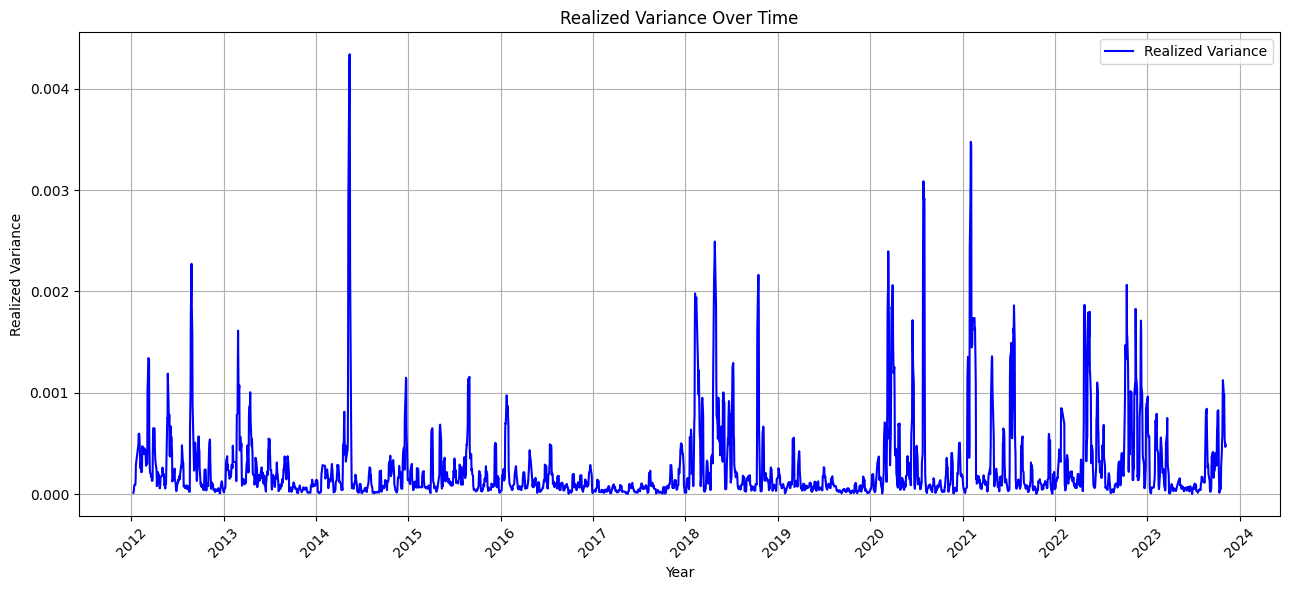

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter

plt.figure(figsize=(13, 6))
plt.plot(df['Date'], df['Realized_Volatility'], label='Realized Variance', color='blue')  

plt.gca().xaxis.set_major_locator(YearLocator())  
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  
plt.xlabel('Year')
plt.ylabel('Realized Variance')
plt.title('Realized Variance Over Time')
plt.legend()

plt.grid(True)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Maximum Likelihood Estimation

Likelihood function


The corresponding log-likelihood function $\ln(\Theta) := \ln f(Y_{t+\Delta t}, V_{t+\Delta t} \mid \Theta)$ is
\begin{equation}
\begin{aligned}
\ln(\Theta) = &-T \ln \left( 2\pi\sigma\sqrt{1-\rho^2}\Delta t \right) - \sum_{t=1}^T \ln(V_t) - \frac{1}{2(1-\rho^2)} \sum_{t=1}^T \left[ (Z^{(S)})^2 - 2\rho Z^{(S)} Z^{(V)} + (Z^{(V)})^2 \right]
\end{aligned}
\end{equation}
with $Z^{(S)}, Z^{(V)}$ from Eqs. (\ref{Z^S}) and (\ref{Z^V}) respectively.

\begin{equation}
\begin{aligned}
\ln(\Theta) = &-T \ln \left( 2\pi\sigma\sqrt{1-\rho^2}\Delta t \right) \\
&- \sum_{t=1}^T \ln(V_t) \\
&- \frac{1}{2(1-\rho^2)} \sum_{t=1}^T \left[ \left( \frac{ Y_{t+\Delta t} - (r - \frac{1}{2} V_t) \Delta t}{\sqrt{\Delta t V_t}} \right)^2 \right. \\
&- 2\rho \left( \frac{ Y_{t+\Delta t} - (r - \frac{1}{2} V_t) \Delta t}{\sqrt{\Delta t V_t}} \right) \left( \frac{ V_{t+\Delta t} - \kappa \theta \Delta t - (1 - \kappa \Delta t) V_t}{\sigma \sqrt{\Delta t V_t}} \right) \\
&+ \left. \left( \frac{ V_{t+\Delta t} - \kappa \theta \Delta t - (1 - \kappa \Delta t) V_t}{\sigma \sqrt{\Delta t V_t}} \right)^2 \right]
\end{aligned}
\end{equation}

$\text{Var}_t(\text{Log\_Return}) = \frac{1}{t-1} \sum_{i=1}^{t} \left( \text{Log\_Return}_i - \bar{Y}_t \right)^2$


# MLE

In [ ]:
def negative_log_likelihood(params, Y, V, delta_t):
    
    r, kappa, rho, sigma, theta = params
    
    neg_log_lik = 0
    
    T = len(Y) - 1  

    term1 = T * np.log(2 * np.pi * sigma * np.sqrt(1 - rho**2) * delta_t)
    if np.isnan(term1) or np.isinf(term1):
        return np.inf  
    
    sum_term2 = 0  
    sum_term3 = 0  
    for t in range(T):
    
        if V.iloc[t] <= 0 or V.iloc[t+1] <= 0:
            return np.inf
        
        Z_S = (Y.iloc[t+1] - (r - 0.5 * V.iloc[t]) * delta_t) / np.sqrt(delta_t * V.iloc[t])
        Z_V = (V.iloc[t+1] - kappa * theta * delta_t - (1 - kappa * delta_t) * V.iloc[t]) / (sigma * np.sqrt(delta_t * V.iloc[t]))
        
        term2 = np.log(V.iloc[t])
        
        term3 = (Z_S**2 - 2 * rho * Z_S * Z_V + Z_V**2) / (2 * (1 - rho**2))
        
        if np.isnan(term2) or np.isnan(term3) or np.isinf(term3):
            return np.inf
        
        sum_term2 += term2
        sum_term3 += term3
    
    neg_log_lik = term1 + sum_term2 + sum_term3
    
    return neg_log_lik


def objective(params, Y, V, delta_t):
    return negative_log_likelihood(params, Y, V, delta_t)


initial_guess =  [0.0003952159163343249, 0.529893587487027, -0.1529884058035907, 0.0079505239215345, 0.0002504613428472]

bounds = [
    (None, None),  # r can be any value (no restriction)
    (1e-3, None),     # kappa > 0
    (-1+1e-10 , 1-1e-10 ),       # -1 < rho <= 1 (correlation constraint remains the same)
    (1e-14, None),     # sigma > 0
    (1e-4, None)      # theta > 0
]

# Data
delta_t = 1  # Time interval
Y = df['Log_Return']
V = df['Realized_Volatility']


# Optimize the log-likelihood function to estimate parameters   method='L-BFGS-B', method='TNC', method='SLSQP' (FAST), method='trust-constr'
result = minimize(objective, initial_guess, args=(Y, V, delta_t), bounds=bounds, method='SLSQP')

r = result.x[0]
kappa = result.x[1]
rho = result.x[2]
sigma = result.x[3]
theta = result.x[4]

mle_params = result.x

print(f"Estimated parameters:")
print(f"r: {r:.16f}")
print(f"kappa: {kappa:.16f}")
print(f"rho: {rho:.16f}")
print(f"sigma: {sigma:.16f}")
print(f"theta: {theta:.16f}")

print("---------------------------")
print("Checking Feller's Condition")
print(2 * kappa * theta - (sigma)**2)


Estimated parameters:
r: 0.0003952159163343
kappa: 0.5298935874870270
rho: -0.1529884058035907
sigma: 0.0079505239215345
theta: 0.0002504613428472
---------------------------
Checking Feller's Condition
0.0002022248883493497


In [192]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28039.870082742087
       x: [ 3.952e-04  5.299e-01 -1.530e-01  7.951e-03  2.505e-04]
     nit: 5
     jac: [ 6.130e+04  1.724e+04 -9.715e+02 -1.035e+06  3.618e+07]
    nfev: 6
    njev: 1

In [193]:
print(2 * kappa * theta*1 - (sigma)**2)

0.0002022248883493497


In [ ]:
# Finite difference Hessian computation
def compute_hessian(params, Y, V, delta_t, h=1e-1):
    n_params = len(params)
    hessian = np.zeros((n_params, n_params))
    base_value = negative_log_likelihood(params, Y, V, delta_t)

    for i in range(n_params):
        for j in range(n_params):
            params_ij = np.copy(params)
            params_i = np.copy(params)
            params_j = np.copy(params)

            params_ij[i] += h
            params_ij[j] += h
            params_i[i] += h
            params_j[j] += h

            f_ij = negative_log_likelihood(params_ij, Y, V, delta_t)
            f_i = negative_log_likelihood(params_i, Y, V, delta_t)
            f_j = negative_log_likelihood(params_j, Y, V, delta_t)

            hessian[i, j] = (f_ij - f_i - f_j + base_value) / (h**2)

    return hessian

hessian_matrix = compute_hessian(mle_params, Y, V, delta_t)

cov_matrix = np.linalg.inv(-hessian_matrix)

standard_errors = np.sqrt(np.diag(cov_matrix))

# Define the critical values for different significance levels
critical_values = {
    '10%': 1.645,  
    '5%': 1.96,    
    '1%': 2.576    #
}



In [ ]:
param_names = ['r', 'kappa', 'rho', 'sigma', 'theta']
print("\nParameter Estimates, Standard Errors, and Statistical Significance:")
for name, estimate, se in zip(param_names, mle_params, standard_errors):
    t_stat = estimate / se
    abs_t_stat = abs(t_stat) 
    significance_results = {level: abs_t_stat > critical_values[level] for level in critical_values}

    print(f"{name}: Estimate = {estimate:.16f}, Std. Error = {se:.16f}, "
          f"t-statistic = {t_stat:.4f}, "
          f"Significant (10%) = {significance_results['10%']}, "
          f"Significant (5%) = {significance_results['5%']}, "
          f"Significant (1%) = {significance_results['1%']}")



Parameter Estimates, Standard Errors, and Statistical Significance:
r: Estimate = 0.0003952159163343, Std. Error = 0.0001525663868530, t-statistic = 2.5905, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True
kappa: Estimate = 0.5298935874870270, Std. Error = 0.0028129635039555, t-statistic = 188.3756, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True
rho: Estimate = -0.1529884058035907, Std. Error = 0.0098380457232251, t-statistic = -15.5507, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True
sigma: Estimate = 0.0079505239215345, Std. Error = 0.0011906952118104, t-statistic = 6.6772, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True
theta: Estimate = 0.0002504613428472, Std. Error = 0.0000000050985110, t-statistic = 49124.4099, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True


In [196]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28039.870082742087
       x: [ 3.952e-04  5.299e-01 -1.530e-01  7.951e-03  2.505e-04]
     nit: 5
     jac: [ 6.130e+04  1.724e+04 -9.715e+02 -1.035e+06  3.618e+07]
    nfev: 6
    njev: 1

### Monte Carlo Simulation

#### Define Parameters
Here we just define the parameters of the model under risk-neutral dynamics, however in a following tutorial I will show how to calibrate Heston model parameters under risk-neutral dynamics to real option market prices.

#### Monte Carlo Simulation
Because we have a recursive function, we have to step through time within our simulation. However we can simulate the Brownian motions of the asset and variances outside of the for loop.

In [ ]:
def heston_model_sim(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
   
    dt = T / N  
    S = np.zeros((N , M))
    v = np.zeros((N, M))


    S[0] = S0
    v[0] = v0

    
    mu = np.array([0, 0])  # Drift of the Brownian motions
    cov = np.array([[1, rho], [rho, 1]])  
    Z = np.random.multivariate_normal(mu, cov, (N, M))  

    for i in range(0, N-1):
        S[i+1] = S[i] * np.exp((r - 0.5 * v[i]) * dt + np.sqrt(v[i ] * dt) * Z[i , :, 0])

        v[i+1] = v[i] + kappa * (theta - v[i]) * dt + sigma * np.sqrt(v[i] * dt) * Z[i, :, 1]   ## absolute scheme, weak order of convergence = 1

    return S, v

In [ ]:
# Parameters from MLE estimation
S0 = df['Price'].iloc[-1]  
v0 = df['Realized_Volatility'].iloc[-1]  
r = result.x[0]           
kappa = result.x[1]       
rho = result.x[2]         
sigma = result.x[3]       
theta = result.x[4]       

T = 1            
N = 252            
M = 10000           

# Simulate using the Heston model
S_sim, v_sim = heston_model_sim(S0, v0, r, kappa, theta, sigma, rho, T, N, M)



In [ ]:
2*kappa*theta - sigma**2

0.0002022248883493497

In [201]:
S0 = df['Price'].iloc[-1]
print(S0)

1089.66


In [202]:
S_mean = 0
S_array = []
for i in range(M):
    S_mean += S_sim[-1, i]
    S_array.append(S_sim[-1, i])
S_mean /= M
S_array.sort()
S_med = (S_array[M//2-1]+S_array[M//2])/2
V_mean = 0
V_array = []
for i in range(M):
    V_mean += v_sim[-1, i]
    V_array.append(v_sim[-1, i])
V_mean /= M
V_array.sort()
V_med = (V_array[M//2-1]+V_array[M//2])/2

#### Plotting the asset prices and variance over time

In [206]:
S_sim

array([[1089.66      , 1089.66      , 1089.66      , ..., 1089.66      ,
        1089.66      , 1089.66      ],
       [1088.56925005, 1088.15661406, 1090.90506202, ..., 1086.24167352,
        1088.56807389, 1091.12252958],
       [1089.79114452, 1087.18555441, 1090.78147534, ..., 1087.218821  ,
        1087.70217405, 1092.85199884],
       ...,
       [1083.74653493, 1073.20923589, 1084.36695379, ..., 1066.80180162,
        1024.67848222, 1067.68318124],
       [1083.89559864, 1071.05763345, 1084.6977664 , ..., 1066.69546312,
        1024.84656753, 1067.13971524],
       [1086.84205327, 1069.59150319, 1084.45334721, ..., 1066.4765198 ,
        1025.69643083, 1067.60229853]])

In [207]:
historical_dates = pd.to_datetime(df['Date'])
prediction_days = 252
prediction_range = pd.date_range(historical_dates.iloc[-1]+pd.Timedelta(days=1),historical_dates.iloc[-1] + pd.Timedelta(days=prediction_days),freq='d').to_list()
whole_dates = historical_dates.to_list()+prediction_range
len(whole_dates)

3204

C:\Users\Hoang Dung Vu Minh\AppData\Local\Temp\ipykernel_15004\3278115040.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_hist.legend()


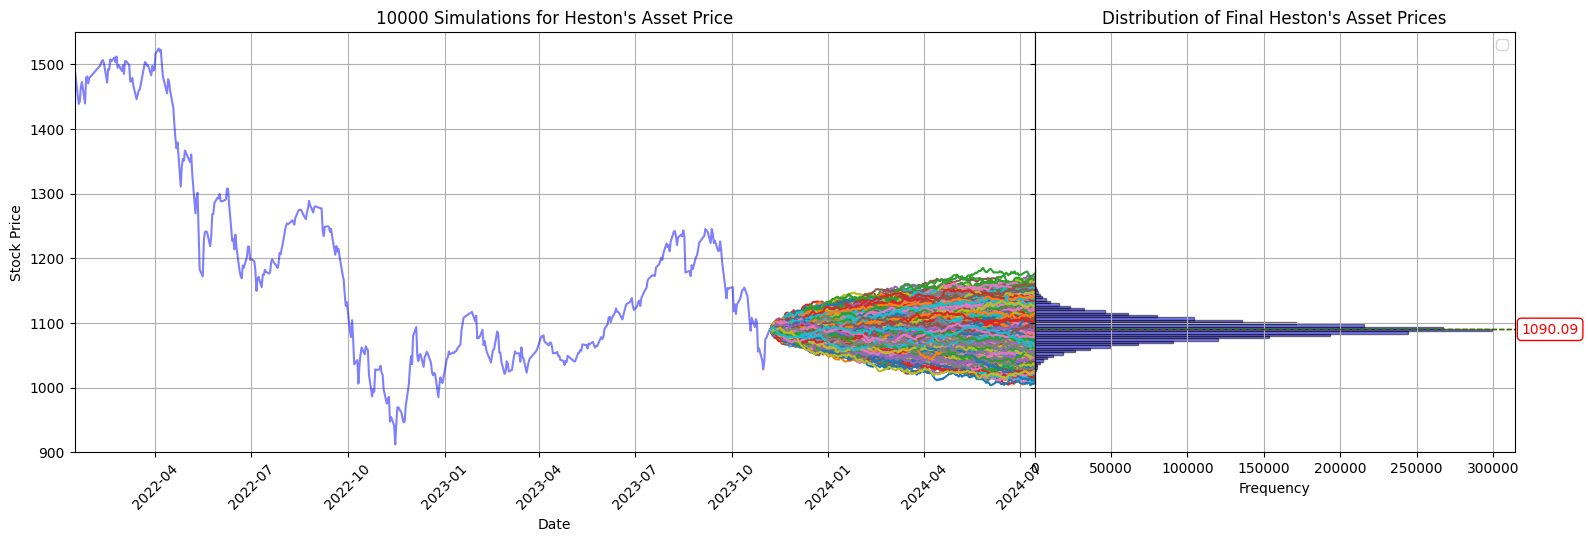

<Figure size 640x480 with 0 Axes>

In [208]:
fig, (ax_sim, ax_hist) = plt.subplots(
        1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [2, 1]}
    )
initial_dates = historical_dates
historical_prices = df['Price'].to_list()
ax_sim.plot(
    initial_dates,
    historical_prices,
    color="blue",
    alpha=0.5,
    label="Historical Prices",
)
ax_sim.plot(prediction_range,S_sim)
ax_sim.set(
    title=f"10000 Simulations for Heston's Asset Price",
    xlabel="Date",
    ylabel="Stock Price",
    xlim=[whole_dates[2500], whole_dates[-1]],
    ylim=[900, 1550],
)
#ax_sim.legend(loc="upper left")
ax_sim.grid(True)
plt.setp(ax_sim.xaxis.get_majorticklabels(), rotation=45)
ax_hist.set_ylim(ax_sim.get_ylim())
plt.setp(ax_hist.get_yticklabels(), visible=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0)
ax_hist.hist(
    np.ravel(S_sim), bins=50, alpha=0.5, edgecolor="k", orientation="horizontal", color="blue"
)
ax_hist.set(
    title="Distribution of Final Heston's Asset Prices", xlabel="Frequency"
)
ax_hist.grid(True)
ax_hist.legend()
ax_hist.axhline(
    S_mean,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Mean Final Price",
)
ax_hist.axhline(
    S_med,
    color="green",
    linestyle="dashed",
    linewidth=1,
    label="Median Final Price",
)
ax_hist.annotate(
    f"{S_mean:.2f}",
    xy=(1, S_mean),
    xycoords=("axes fraction", "data"),
    xytext=(5, 0),
    textcoords="offset points",
    color="red",
    ha="left",
    va="center",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.3"),
)
ax_hist.set_ylim(ax_sim.get_ylim())
plt.setp(ax_hist.get_yticklabels(), visible=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0)
plt.show()

plt.savefig("Heston's Asset Price.png")

In [209]:
v_sim

array([[0.00049112, 0.00049112, 0.00049112, ..., 0.00049112, 0.00049112,
        0.00049112],
       [0.0004933 , 0.00049977, 0.00047081, ..., 0.0004967 , 0.00050152,
        0.00047725],
       [0.00047097, 0.00049591, 0.00047665, ..., 0.00047154, 0.00049421,
        0.0004662 ],
       ...,
       [0.00045659, 0.00025271, 0.00041934, ..., 0.00035888, 0.00062749,
        0.00054646],
       [0.00047297, 0.00025605, 0.00042291, ..., 0.00034662, 0.00063503,
        0.0005574 ],
       [0.000467  , 0.00026005, 0.00041387, ..., 0.0003598 , 0.0006386 ,
        0.00056152]])

C:\Users\Hoang Dung Vu Minh\AppData\Local\Temp\ipykernel_15004\3626812357.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_hist.legend()


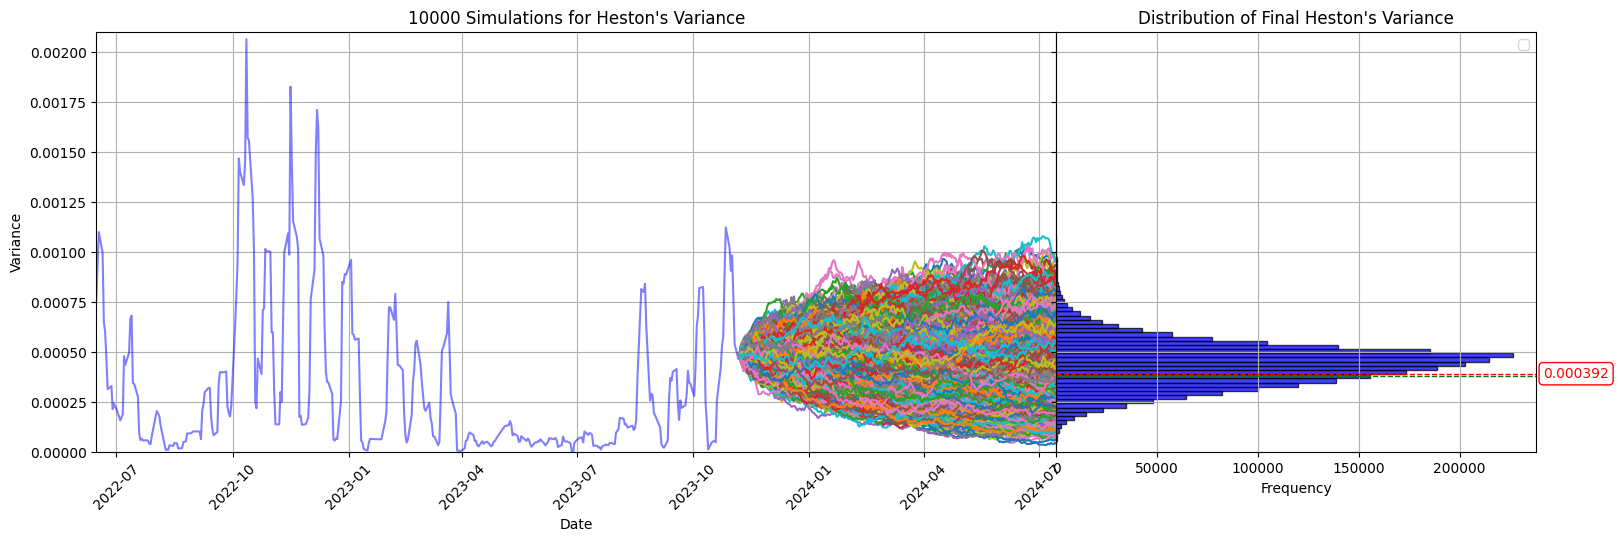

In [ ]:
fig, (ax_sim, ax_hist) = plt.subplots(
        1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [2, 1]}
    )
initial_dates = historical_dates
historical_prices = df['Realized_Volatility'].to_list()
ax_sim.plot(
    initial_dates,
    historical_prices,
    color="blue",
    alpha=0.5,
    label="Historical Variance",
)
ax_sim.plot(prediction_range,v_sim)
ax_sim.set(
    title=f"10000 Simulations for Heston's Variance",
    xlabel="Date",
    ylabel="Variance",
    xlim=[whole_dates[2600], whole_dates[-1]],
    ylim=[0,0.0021],
)
#ax_sim.legend(loc="upper left")
ax_sim.grid(True)
plt.setp(ax_sim.xaxis.get_majorticklabels(), rotation=45)
ax_hist.set_ylim(ax_sim.get_ylim())
plt.setp(ax_hist.get_yticklabels(), visible=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0)
ax_hist.hist(
    np.ravel(v_sim), bins=50, alpha=0.75, edgecolor="k", orientation="horizontal", color="blue"
)
ax_hist.set(
    title="Distribution of Final Heston's Variance", xlabel="Frequency"
)
ax_hist.grid(True)
ax_hist.legend()
ax_hist.axhline(
    V_mean,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Mean Final Price",
)
ax_hist.axhline(
    V_med,
    color="green",
    linestyle="dashed",
    linewidth=1,
    label="Median Final Price",
)
ax_hist.annotate(
    f"{V_mean:.6f}",
    xy=(1, V_mean),
    xycoords=("axes fraction", "data"),
    xytext=(5, 0),
    textcoords="offset points",
    color="red",
    ha="left",
    va="center",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.3"),
)

ax_hist.set_ylim(ax_sim.get_ylim())
plt.setp(ax_hist.get_yticklabels(), visible=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0)
plt.show()



#### GBM

In [212]:
r,sigma

(0.0003952159163343249, 0.0079505239215345)

In [ ]:

delta_t = 1 
X = df['Log_Return'].values  
n = len(df['Log_Return'])
T = len(df['Log_Return']) 

def log_likelihood(params, X, T, n):
    if len(params) != 2:
        raise ValueError(f"Expected 2 parameters (mu, sigma2), got {len(params)}: {params}")
    mu, sigma2 = params
    X = np.array(X)
    
    if sigma2 <= 0:
        return -np.inf
    
    term1 = -n * np.log(np.sqrt(sigma2))
    term2 = -(n/2) * np.log((T/n) * 2 * np.pi)
    drift = mu - (0.5 * sigma2)
    mean_term = drift * (T/n)
    variance_term = sigma2 * (T/n)
    sum_term = np.sum((X - mean_term)**2) / (2 * variance_term)
    
    ll = term1 + term2 - sum_term
    return ll

def neg_log_likelihood(params, X, T, n):
    return -log_likelihood(params, X, T, n)

initial_guess = [0.0003952159163343249, 0.0002504613428472]

result = minimize(neg_log_likelihood, initial_guess, args=(X, T, n),
                 bounds=[(-np.inf, np.inf), (1e-10, np.inf)],
                 method='L-BFGS-B')

mle_params = result.x  
estimated_mu = mle_params[0]
estimated_sigma2 = mle_params[1]

# Finite difference Hessian computation
def compute_hessian(params, X, T, n, h=1e-6):
    n_params = len(params)
    if n_params != 2:
        raise ValueError(f"Expected 2 parameters in Hessian computation, got {n_params}")
    hessian = np.zeros((n_params, n_params))
    base_value = neg_log_likelihood(params, X, T, n)

    for i in range(n_params):
        for j in range(n_params):
            params_ij = np.copy(params)
            params_i = np.copy(params)
            params_j = np.copy(params)

            params_ij[i] += h
            params_ij[j] += h
            params_i[i] += h
            params_j[j] += h

            f_ij = neg_log_likelihood(params_ij, X, T, n)
            f_i = neg_log_likelihood(params_i, X, T, n)
            f_j = neg_log_likelihood(params_j, X, T, n)

            hessian[i, j] = (f_ij - f_i - f_j + base_value) / (h**2)

    return hessian

# Compute Hessian
hessian_matrix = compute_hessian(mle_params, X, T, n)

# Covariance matrix
try:
    cov_matrix = np.linalg.inv(-hessian_matrix)
    if not np.all(np.diag(cov_matrix) > 0):
        print("Covariance matrix has non-positive diagonal elements:", np.diag(cov_matrix))
except np.linalg.LinAlgError:
    print("Error: Hessian matrix is singular")
    cov_matrix = None

# Standard errors
if cov_matrix is not None and np.all(np.diag(cov_matrix) > 0):
    standard_errors_sigma2 = np.sqrt(np.diag(cov_matrix))
    estimated_sigma = np.sqrt(mle_params[1])
    se_sigma = standard_errors_sigma2[1] / (2 * estimated_sigma)
    standard_errors = [standard_errors_sigma2[0], se_sigma]
    method = "Numerical"
else:
    print("Using analytical standard errors due to numerical issues")
    mu, sigma2 = mle_params
    estimated_sigma = np.sqrt(sigma2)
    se_mu = estimated_sigma / np.sqrt(n)  # sqrt(sigma^2 / (n * delta_t))
    se_sigma = estimated_sigma / np.sqrt(2 * n)  # sigma / sqrt(2n)
    standard_errors = [se_mu, se_sigma]
    method = "Analytical"

# Critical values
critical_values = {'10%': 1.645, '5%': 1.96, '1%': 2.576}

# Print results
param_names = ['mu', 'sigma']
param_values = [mle_params[0], estimated_sigma]
print(f"\nParameter Estimates, Standard Errors, and Statistical Significance (Method: {method}, n = {n}):")
for name, estimate, se in zip(param_names, param_values, standard_errors):
    t_stat = estimate / se if se != 0 else np.nan
    abs_t_stat = abs(t_stat)
    significance_results = {level: abs_t_stat > critical_values[level] for level in critical_values}

    print(f"{name}: Estimate = {estimate:.16f}, Std. Error = {se:.16f}, "
          f"t-statistic = {t_stat:.4f}, "
          f"Significant (10%) = {significance_results['10%']}, "
          f"Significant (5%) = {significance_results['5%']}, "
          f"Significant (1%) = {significance_results['1%']}")

Covariance matrix has non-positive diagonal elements: [-4.60554823e-08 -1.28927371e-11]
Using analytical standard errors due to numerical issues

Parameter Estimates, Standard Errors, and Statistical Significance (Method: Analytical, n = 2952):
mu: Estimate = 0.0004631739177453, Std. Error = 0.0002145979002015, t-statistic = 2.1583, Significant (10%) = True, Significant (5%) = True, Significant (1%) = False
sigma: Estimate = 0.0116595998169593, Std. Error = 0.0001517436304609, t-statistic = 76.8375, Significant (10%) = True, Significant (5%) = True, Significant (1%) = True


### Asset price distribution with different correlations

In [ ]:

estimated_mu = 0.0004631891504719
estimated_sigma2 = 0.0116595389306899**2

gbm = S0 * np.exp((estimated_mu - estimated_sigma2 **2 / 2) * 1 + np.sqrt(estimated_sigma2) * np.sqrt(1) * np.random.normal(0, 1, M))
gbm

array([1099.11715155, 1086.98693361, 1073.42845948, ..., 1079.73115721,
       1074.68445492, 1068.10093375])

In [222]:
from scipy.stats import skew, kurtosis

heston_var = np.var(S_sim[-1])
gbm_var = np.var(gbm)
heston_skew = skew(S_sim[-1])
gbm_skew = skew(gbm)
heston_kurt = kurtosis(S_sim[-1])
gbm_kurt = kurtosis(gbm)

print(f"Heston - Var: {heston_var:.2f}, Skew: {heston_skew:.2f}, Kurt: {heston_kurt:.2f}")
print(f"GBM - Var: {gbm_var:.2f}, Skew: {gbm_skew:.2f}, Kurt: {gbm_kurt:.2f}")

Heston - Var: 524.88, Skew: -0.01, Kurt: 0.06
GBM - Var: 161.75, Skew: 0.01, Kurt: -0.02


In [223]:
alpha = 0.05  # 5% VaR
heston_var_price = np.percentile(S_sim[-1], alpha * 100)
gbm_var_price = np.percentile(gbm, alpha * 100)
heston_cvar = np.mean(S_sim[-1][S_sim[-1] <= heston_var])
gbm_cvar = np.mean(gbm[gbm <= gbm_var])

print(f"Heston - VaR: {heston_var:.2f}, CVaR: {heston_cvar:.2f}")
print(f"GBM - VaR: {gbm_var:.2f}, CVaR: {gbm_cvar:.2f}")

Heston - VaR: 524.88, CVaR: nan
GBM - VaR: 161.75, CVaR: nan


c:\Users\Hoang Dung Vu Minh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Hoang Dung Vu Minh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


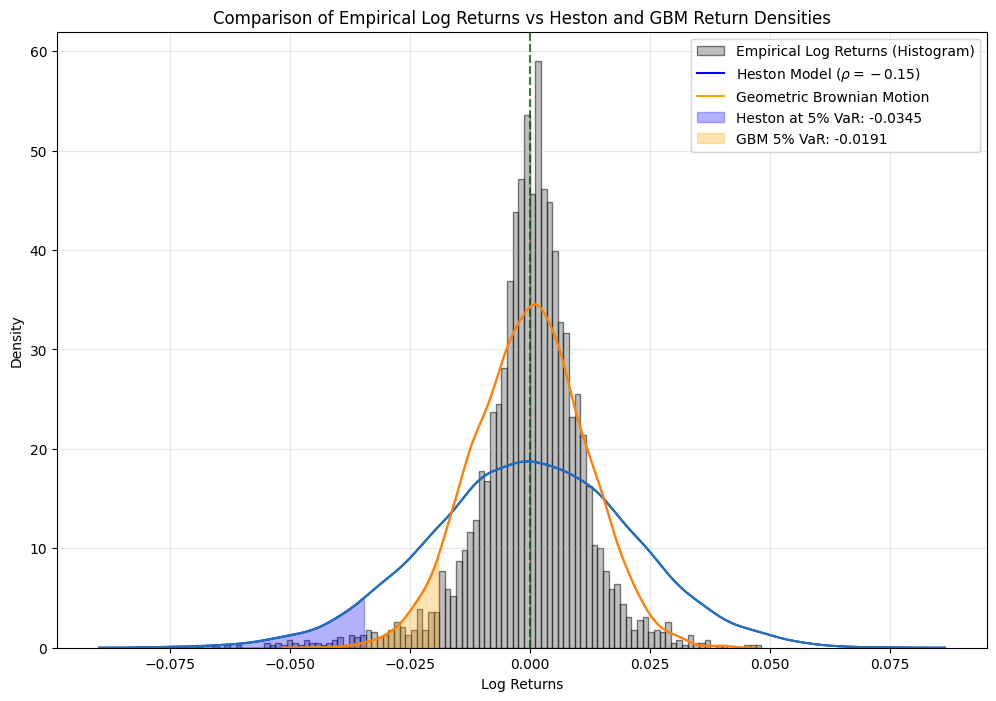

heston_returns NaN count: 0
heston_returns Inf count: 0
gbm_returns NaN count: 0
gbm_returns Inf count: 0


In [ ]:

plt.figure(figsize=(12, 8))

df_returns_mean = np.mean(merged_df['Log_Return'])

plt.hist(merged_df['Log_Return']-df_returns_mean, bins=100, density=True, edgecolor='black', color='gray', 
         alpha=0.5, label='Empirical Log Returns (Histogram)')

heston_returns_no_shift = np.log(S_sim[-1]) - np.log(S0) 
gbm_returns_no_shift = np.log(gbm) - np.log(S0) 

heston_mean_no_shift = np.mean(heston_returns_no_shift)
gbm_mean_no_shift = np.mean(gbm_returns_no_shift)

heston_returns  = heston_returns_no_shift- heston_mean_no_shift
gbm_returns=gbm_returns_no_shift- gbm_mean_no_shift

##
heston_mean= np.mean(heston_returns)
gbm_mean = np.mean(gbm_returns)

# Calculate 5% VaR
alpha = 0.05
heston_var_return = np.percentile(heston_returns, alpha * 100)
gbm_var_return = np.percentile(gbm_returns, alpha * 100)

# Plot KDEs
sns.kdeplot(heston_returns, label=r"Heston Model ($\rho = -0.15$)", color='blue')
sns.kdeplot(gbm_returns, label="Geometric Brownian Motion", color='orange')

text_offset = 0.02
plt.axvline(heston_mean, color='black', linestyle='--', alpha=0.5)
plt.axvline(gbm_mean, color='green', linestyle='--', alpha=0.5)

# Highlight 5% VaR regions
# For Heston
x_heston = np.linspace(min(heston_returns), heston_var_return, 100)
kde_heston = sns.kdeplot(heston_returns).get_lines()[0].get_data()
plt.fill_between(x_heston, 0, np.interp(x_heston, kde_heston[0], kde_heston[1]), 
                 color='blue', alpha=0.3, label=f'Heston at 5% VaR: {heston_var_return:.4f}')

# For GBM
x_gbm = np.linspace(min(gbm_returns), gbm_var_return, 100)
kde_gbm = sns.kdeplot(gbm_returns).get_lines()[1].get_data()
plt.fill_between(x_gbm, 0, np.interp(x_gbm, kde_gbm[0], kde_gbm[1]), 
                 color='orange', alpha=0.3, label=f'GBM 5% VaR: {gbm_var_return:.4f}')

# Customize the plot
plt.title('Comparison of Empirical Log Returns vs Heston and GBM Return Densities')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("heston_returns NaN count:", np.isnan(heston_returns).sum())
print("heston_returns Inf count:", np.isinf(heston_returns).sum())
print("gbm_returns NaN count:", np.isnan(gbm_returns).sum())
print("gbm_returns Inf count:", np.isinf(gbm_returns).sum())

$T = N \times \Delta t$

In [ ]:
T = len(df_test)/252           
N = len(df_test)          
M = 10000             

S_sim_forecast, v_sim_forecast = heston_model_sim(S0, v0, r, kappa, theta, sigma, rho, T, N, M)

In [ ]:
T = len(df_test)/252           
N = len(df_test) 

T/N

print( (10/252)/ 10 )

0.003968253968253968


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

S0 = df_test['Price'].iloc[0]  
mu = 0.0004631891504719    
sigma = 0.0116595389306899 
N = len(df_test)  
T = N / 252       
M = 10000         
dt = T / N     


t = np.linspace(0, T, N)


W = np.random.normal(0, np.sqrt(dt), (M, N)).cumsum(axis=1)
paths = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)  
actual_prices = df_test['Price'].to_numpy() 

mean_estimates = np.mean(paths, axis=0)    
median_estimates = np.median(paths, axis=0) 
horizons = {
    'T_f=5': 5,    # Weekly
    'T_f=22': 22,   # Monthly
    'T_f=252': 252  # Yearly
}


errors_mean_dict = {}
errors_median_dict = {}

for horizon_name, horizon_length in horizons.items():
   
    S_sim_forecast_horizon = paths[:, :horizon_length]  
    actual_prices_horizon = actual_prices[:horizon_length] 
    mean_prices_horizon = np.mean(S_sim_forecast_horizon, axis=0)  
    median_prices_horizon = np.median(S_sim_forecast_horizon, axis=0)
    
    # Errors for Mean Forecast
    errors_mean_horizon = actual_prices_horizon - mean_prices_horizon
    mse_mean = np.mean(errors_mean_horizon**2)
    rmse_mean = np.sqrt(mse_mean)
    mae_mean = np.mean(np.abs(errors_mean_horizon))
    mape_mean = np.mean(np.abs(errors_mean_horizon / actual_prices_horizon)) if np.all(actual_prices_horizon != 0) else np.nan
    errors_mean_dict[horizon_name] = {'RMSE': rmse_mean, 'MAE': mae_mean, 'MAPE': mape_mean}
    
    # Errors for Median Forecast
    errors_median_horizon = actual_prices_horizon - median_prices_horizon
    mse_median = np.mean(errors_median_horizon**2)
    rmse_median = np.sqrt(mse_median)
    mae_median = np.mean(np.abs(errors_median_horizon))
    mape_median = np.mean(np.abs(errors_median_horizon / actual_prices_horizon)) if np.all(actual_prices_horizon != 0) else np.nan
    errors_median_dict[horizon_name] = {'RMSE': rmse_median, 'MAE': mae_median, 'MAPE': mape_median}

# Print results
for horizon_name in horizons.keys():
    print(f"{horizon_name}:")
    print("Mean Forecast:")
    print(f"RMSE: {errors_mean_dict[horizon_name]['RMSE']:.5f}")
    print(f"MAE: {errors_mean_dict[horizon_name]['MAE']:.5f}")
    print(f"MAPE: {errors_mean_dict[horizon_name]['MAPE']:.5f}")
    print("Median Forecast:")
    print(f"RMSE: {errors_median_dict[horizon_name]['RMSE']:.5f}")
    print(f"MAE: {errors_median_dict[horizon_name]['MAE']:.5f}")
    print(f"MAPE: {errors_median_dict[horizon_name]['MAPE']:.5f}")

T_f=5:
Mean Forecast:
RMSE: 15.74867
MAE: 11.47871
MAPE: 0.01036
Median Forecast:
RMSE: 15.76139
MAE: 11.48447
MAPE: 0.01036
T_f=22:
Mean Forecast:
RMSE: 17.80035
MAE: 14.28752
MAPE: 0.01286
Median Forecast:
RMSE: 17.78707
MAE: 14.27403
MAPE: 0.01285
T_f=252:
Mean Forecast:
RMSE: 159.87763
MAE: 148.26113
MAPE: 0.11756
Median Forecast:
RMSE: 159.92519
MAE: 148.29992
MAPE: 0.11759


In [ ]:
import numpy as np

actual_realized_vol = df_test['Realized_Volatility'].to_numpy()


horizons = {
    'T_f=5': 5,   
    'T_f=22': 22,   
    'T_f=252': 252 
}

errors_mean_vol_dict = {}
errors_median_vol_dict = {}


for horizon_name, horizon_length in horizons.items():

    v_sim_forecast_horizon = v_sim_forecast[:horizon_length, :]  
    actual_realized_vol_horizon = actual_realized_vol[:horizon_length]  
    mean_vol_horizon = np.mean(v_sim_forecast_horizon, axis=1)  
    median_vol_horizon = np.median(v_sim_forecast_horizon, axis=1)  
    errors_mean_vol_horizon = actual_realized_vol_horizon - mean_vol_horizon

    mse_mean_vol = np.mean(errors_mean_vol_horizon**2)
    rmse_mean_vol = np.sqrt(mse_mean_vol) * 100

    mae_mean_vol = np.mean(np.abs(errors_mean_vol_horizon)) * 100

    mape_mean_vol = np.mean(np.abs(errors_mean_vol_horizon / actual_realized_vol_horizon))  

    errors_mean_vol_dict[horizon_name] = {'RMSE': rmse_mean_vol, 'MAE': mae_mean_vol, 'MAPE': mape_mean_vol}

    errors_median_vol_horizon = actual_realized_vol_horizon - median_vol_horizon

    mse_median_vol = np.mean(errors_median_vol_horizon**2)
    rmse_median_vol = np.sqrt(mse_median_vol) * 100

    mae_median_vol = np.mean(np.abs(errors_median_vol_horizon)) * 100

    mape_median_vol = np.mean(np.abs(errors_median_vol_horizon / actual_realized_vol_horizon))  

    errors_median_vol_dict[horizon_name] = {'RMSE': rmse_median_vol, 'MAE': mae_median_vol, 'MAPE': mape_median_vol}


print("Volatility Forecasting Errors for Different Horizons (Heston Model):")
for horizon_name in horizons.keys():
    print(f"{horizon_name}:")
    print("Mean Forecast:")
    print(f"MAE: {errors_mean_vol_dict[horizon_name]['MAE']:.5f}")
    print(f"RMSE: {errors_mean_vol_dict[horizon_name]['RMSE']:.5f}")
    print(f"MAPE: {errors_mean_vol_dict[horizon_name]['MAPE']:.5f}")
    print("Median Forecast:")
    print(f"MAE: {errors_median_vol_dict[horizon_name]['MAE']:.5f}")
    print(f"RMSE: {errors_median_vol_dict[horizon_name]['RMSE']:.5f}")
    print(f"MAPE: {errors_median_vol_dict[horizon_name]['MAPE']:.5f}")

Volatility Forecasting Errors for Different Horizons (Heston Model):
T_f=5:
Mean Forecast:
MAE: 0.00563
RMSE: 0.00689
MAPE: 0.11958
Median Forecast:
MAE: 0.00564
RMSE: 0.00689
MAPE: 0.11964
T_f=22:
Mean Forecast:
MAE: 0.01550
RMSE: 0.01912
MAPE: 0.79163
Median Forecast:
MAE: 0.01545
RMSE: 0.01906
MAPE: 0.78947
T_f=252:
Mean Forecast:
MAE: 0.03362
RMSE: 0.03677
MAPE: 6.86504
Median Forecast:
MAE: 0.03311
RMSE: 0.03636
MAPE: 6.74349


In [ ]:

constant_variance_gbm = 0.0116595998169593**2
array_filled = np.full(348, constant_variance_gbm)

horizon_5 = slice(0, 5)         
horizon_22 = slice(5, 27)     
horizon_252 = slice(27, 279)    
horizon_full = slice(0, 348)    
def calculate_errors(actual, forecast):
    errors = actual - forecast
    mae = np.mean(np.abs(errors)) * 100
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse) * 100
    mape = np.mean(np.abs(errors / actual)) 
    return mae, rmse, mape


results = {}
for horizon, label in zip(
    [horizon_5, horizon_22, horizon_252, horizon_full],
    ["T_f=5", "T_f=22", "T_f=252", "Entire Test Set"]
):
    actual_subset = actual_realized_vol[horizon]
    forecast_subset = array_filled[horizon]
    mae, rmse, mape = calculate_errors(actual_subset, forecast_subset)
    results[label] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

for label, metrics in results.items():
    print(f"\n{label}:")
    print(f"  MAE: {metrics['MAE']:.5f}")
    print(f"  RMSE: {metrics['RMSE']:.5f}")
    print(f"  MAPE: {metrics['MAPE']:.5f}")


T_f=5:
  MAE: 0.03572
  RMSE: 0.03637
  MAPE: 0.71857

T_f=22:
  MAE: 0.01615
  RMSE: 0.02051
  MAPE: 0.47832

T_f=252:
  MAE: 0.01299
  RMSE: 0.02580
  MAPE: 2.00958

Entire Test Set:
  MAE: 0.01254
  RMSE: 0.02329
  MAPE: 2.08103


In [ ]:
mu = 0.0004631891504719    
sigma = 0.0116595389306899
N = len(df_test)  
T = N / 252       
M = 10000         
dt = T / N        
t = np.linspace(0, T, N)

W = np.random.normal(0, np.sqrt(dt), (M, N)).cumsum(axis=1)  
paths = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)  
actual_prices = df_test['Price'].to_numpy()  

mean_estimates = np.mean(paths, axis=0)   
median_estimates = np.median(paths, axis=0) 

forecast_horizons = [5, 22, 252]

errors_mean = actual_prices - mean_estimates
errors_median = actual_prices - median_estimates


for T_f in forecast_horizons:
 
    actual = actual_prices[-T_f:]
    mean_pred = mean_estimates[-T_f:]
    median_pred = median_estimates[-T_f:]
    

    errors_m = actual - mean_pred
    errors_med = actual - median_pred
    
    print(f"T_f = {T_f}")
    
    # Metrics for Mean Estimates
    print("Mean Estimates:")
    mse_mean = np.mean(errors_m**2)
    rmse_mean = np.sqrt(mse_mean)
    mae_mean = np.mean(np.abs(errors_m))
    mape_mean = np.mean(np.abs(errors_m / actual)) if np.all(actual != 0) else np.nan
    
    print(f"RMSE: {rmse_mean:.5f}")
    print(f"MAE: {mae_mean:.5f}")
    print(f"MAPE: {mape_mean:.5f}")
    
    # Metrics for Median Estimates
    print("Median Estimates:")
    mse_median = np.mean(errors_med**2)
    rmse_median = np.sqrt(mse_median)
    mae_median = np.mean(np.abs(errors_med))
    mape_median = np.mean(np.abs(errors_med / actual)) if np.all(actual != 0) else np.nan
    
    print(f"RMSE: {rmse_median:.5f}")
    print(f"MAE: {mae_median:.5f}")
    print(f"MAPE: {mape_median:.5f}")

T_f = 5
Mean Estimates:
RMSE: 235.69549
MAE: 235.63978
MAPE: 0.17771
Median Estimates:
RMSE: 235.79759
MAE: 235.74266
MAPE: 0.17778
T_f = 22
Mean Estimates:
RMSE: 232.66996
MAE: 232.48222
MAPE: 0.17572
Median Estimates:
RMSE: 232.77374
MAE: 232.58553
MAPE: 0.17579
T_f = 252
Mean Estimates:
RMSE: 178.18853
MAE: 175.79381
MAPE: 0.13843
Median Estimates:
RMSE: 178.21649
MAE: 175.81911
MAPE: 0.13845
